In [3]:
import numpy as np

n_arms = 4


class Env:
    thetas = [0.1, 0.1, 0.2, 0.3]

    def react(self, arm: int) -> int:
        """選ばれた腕に対して、報酬を生成して返す"""
        return 1 if np.random.random() < self.thetas[arm] else 0

    def best_arm(self) -> int:
        """最も報酬期待値が大きい腕のインデックスを返す"""
        return int(np.argmax(Env.thetas))


In [18]:
class AgentInterface:
    def get_arm(self) -> int:
        """腕を選択する"""
        raise NotImplementedError

    def sample(self, arm: int, reward: int) -> None:
        """選択した腕と、それに対して観測された報酬を元に、パラメータを更新する"""
        raise NotImplementedError


class EpsilonGreedyAgent(AgentInterface):
    def __init__(self, epsilon: float = 0.1) -> None:
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        # 各腕の報酬期待値の推定値
        self.thetas_hat = np.zeros(n_arms)

    def get_arm(self) -> int:
        """腕を選択する"""
        if np.random.random() < self.epsilon:
            return int(np.random.randint(n_arms))

        return int(np.argmax(self.thetas_hat))

    def sample(self, arm: int, reward: int) -> None:
        """選択した腕と、それに対して観測された報酬を元に、パラメータを更新する"""
        self.counts[arm] += 1
        # 観測された報酬の標本平均を使って報酬期待値を推定 (大数の法則より不偏推定できるはずなので)
        # ここでは計算の効率化のために更新式を使ってる (theta_hat_{n} = (n-1) / n * theta_hat_{n-1} + 1 / n * reward_{n})
        # 更新前の標本平均と回数さえ保持していれば、新しい標本平均を計算できるので
        self.thetas_hat[arm] = ((self.counts[arm] - 1) * self.thetas_hat[arm] + reward) / self.counts[arm]


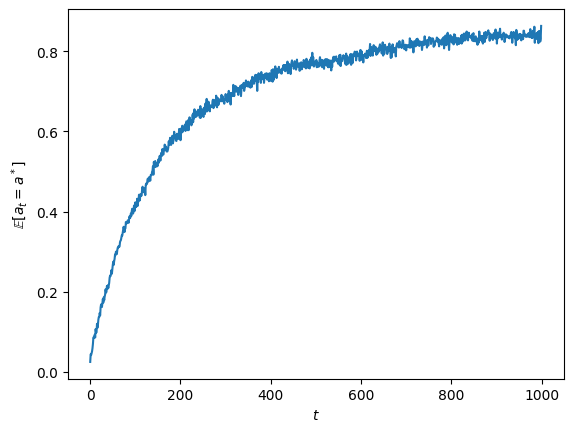

In [19]:
from matplotlib import pyplot as plt


def simulation(
    agent_class: type[AgentInterface],
    env: Env,
    N: int = 1000,
    T: int = 1000,
    **kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    """エージェントが環境とやり取りを行うシミュレーションを行う
    Args:
        agent_class: エージェントのクラス
        env: 環境
        N: シミュレーション回数
        T: 1回のシミュレーションでのエージェントの試行回数
    """
    selected_arms = [[0 for _ in range(T)] for _ in range(N)]
    observed_rewards = [[0 for _ in range(T)] for _ in range(N)]

    for n in range(N):
        agent = agent_class(**kwargs)
        for t in range(T):
            arm = agent.get_arm()
            reward = env.react(arm)
            agent.sample(arm, reward)

            selected_arms[n][t] = arm
            observed_rewards[n][t] = reward

    return np.array(selected_arms), np.array(observed_rewards)


selected_arms, observed_rewards = simulation(EpsilonGreedyAgent, Env())
# 各試行について、報酬期待値が最大の腕を選べた割合を計算
accuracy_list = np.mean(selected_arms == Env().best_arm(), axis=0)

plt.plot(accuracy_list)
plt.xlabel(r"$t$")
plt.ylabel(r"$\mathbb{E}[a_t = a^*]$")
plt.show()

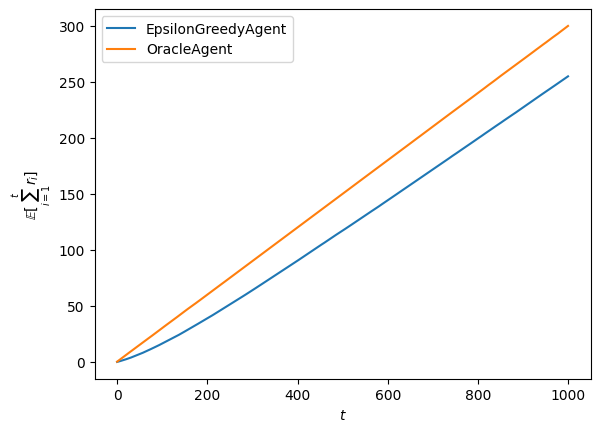

In [20]:
class OracleAgent(AgentInterface):
    """常に理想の行動をとる(報酬期待値が最大の腕を選ぶ)エージェント"""

    def __init__(self) -> None:
        self.arm = Env().best_arm()

    def get_arm(self) -> int:
        return self.arm

    def sample(self, arm: int, reward: int) -> None:
        pass


selected_arms_oracle, observed_rewards_oracle = simulation(OracleAgent, Env())
plt.plot(np.mean(np.cumsum(observed_rewards, axis=1), axis=0), label="EpsilonGreedyAgent")
plt.plot(np.mean(np.cumsum(observed_rewards_oracle, axis=1), axis=0), label="OracleAgent")
plt.xlabel(r"$t$")
plt.ylabel(r"$\mathbb{E}[\sum_{i=1}^{t} r_i]$")
plt.legend()
plt.show()

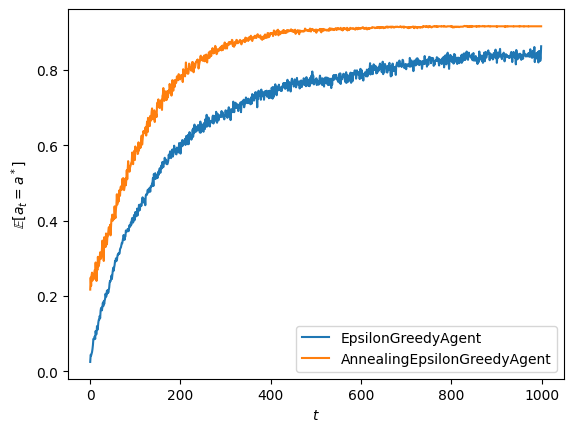

In [21]:
class AnnealingEpsilonGreedyAgent(AgentInterface):
    """焼きなましepsilon-greedy"""

    def __init__(self, epsilon_init: float = 1.0) -> None:
        self.epsilon = epsilon_init
        self.counts = np.zeros(n_arms)
        self.thetas_hat = np.zeros(n_arms)

    def get_arm(self) -> int:
        """epsilonを徐々に小さくしていくことで「最初はランダムな行動をとり、だんだんと落ち着いていく」挙動をとる"""
        if np.random.random() < self.epsilon:
            arm = int(np.random.randint(n_arms))
        else:
            arm = int(np.argmax(self.thetas_hat))

        # epsilonを減衰させる
        self.epsilon *= 0.99
        return arm

    def sample(self, arm: int, reward: int) -> None:
        self.counts[arm] += 1
        # パラメータ更新はEpsilonGreedyAgentと同じ
        self.thetas_hat[arm] = ((self.counts[arm] - 1) * self.thetas_hat[arm] + reward) / self.counts[arm]


# epsilon-greedyと焼きなましepsilon-greedyの精度(最適な腕を選べた割合)を比較
selected_arms_annealing, observed_rewards_annealing = simulation(AnnealingEpsilonGreedyAgent, Env())
plt.plot(np.mean(selected_arms == Env().best_arm(), axis=0), label="EpsilonGreedyAgent")
plt.plot(np.mean(selected_arms_annealing == Env().best_arm(), axis=0), label="AnnealingEpsilonGreedyAgent")
plt.xlabel(r"$t$")
plt.ylabel(r"$\mathbb{E}[a_t = a^*]$")
plt.legend()
plt.show()

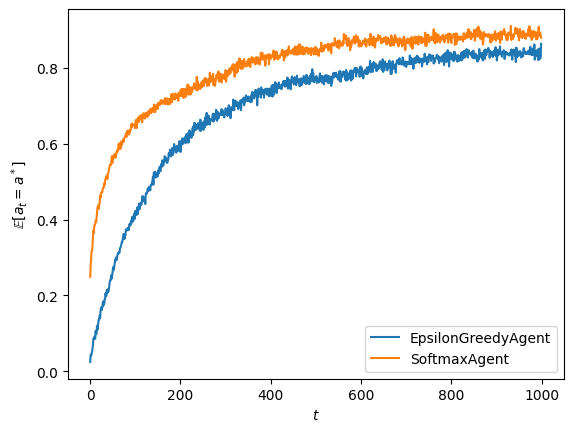

In [23]:
class SoftmaxAgent(AgentInterface):
    def __init__(self, tau: float = 0.05) -> None:
        """softmax関数を使った行動選択を行うエージェント
        Args:
            tau: softmax関数の温度パラメータ。報酬のスケールを補正するために使われる。
        """
        self.tau = tau
        self.counts = np.zeros(n_arms)
        self.thetas_hat = np.zeros(n_arms)

    def get_arm(self) -> int:
        action_probs = self._calc_softmax_params()
        arms = np.random.choice(n_arms, p=action_probs)
        return arms

    def sample(self, arm: int, reward: int) -> None:
        # 標本平均を使って各腕の報酬期待値 E[r|a] を推定する
        self.counts[arm] += 1
        self.thetas_hat[arm] = ((self.counts[arm] - 1) * self.thetas_hat[arm] + reward) / self.counts[arm]

    def _calc_softmax_params(self) -> np.ndarray:
        """ソフトマックス関数を使って、各腕を選択する確率質量関数を計算する"""
        logits = self.thetas_hat / self.tau
        # ここで、各腕のロジット値をそのままexp()に入れると巨大な値になりオーバーフローを起こす可能性がある。
        # 回避するために、ここではロジット値の最大値を引いてからexp()に入れている
        logits = logits - np.max(logits)
        return np.exp(logits) / np.sum(np.exp(logits))


selected_arms_softmax, observed_rewards_softmax = simulation(SoftmaxAgent, Env())
plt.plot(np.mean(selected_arms == Env().best_arm(), axis=0), label="EpsilonGreedyAgent")
plt.plot(np.mean(selected_arms_softmax == Env().best_arm(), axis=0), label="SoftmaxAgent")
plt.xlabel(r"$t$")
plt.ylabel(r"$\mathbb{E}[a_t = a^*]$")
plt.legend()

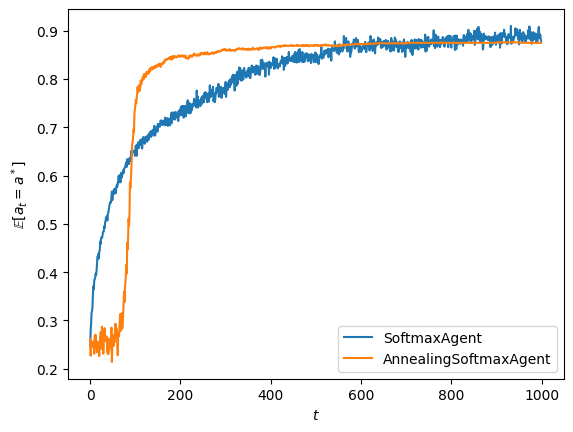

In [25]:
class AnnealingSoftmaxAgent(AgentInterface):
    def __init__(self, tau_init: float = 1000.0) -> None:
        self.tau = tau_init
        self.counts = np.zeros(n_arms)
        self.thetas_hat = np.zeros(n_arms)

    def get_arm(self) -> int:
        action_probs = self._calc_softmax_params()
        arms = np.random.choice(n_arms, p=action_probs)
        self.tau *= 0.9
        return arms

    def sample(self, arm: int, reward: int) -> None:
        self.counts[arm] += 1
        self.thetas_hat[arm] = ((self.counts[arm] - 1) * self.thetas_hat[arm] + reward) / self.counts[arm]

    def _calc_softmax_params(self) -> np.ndarray:
        logits = self.thetas_hat / self.tau
        logits = logits - np.max(logits)
        return np.exp(logits) / np.sum(np.exp(logits))


selected_arms_annealing_softmax, observed_rewards_annealing_softmax = simulation(AnnealingSoftmaxAgent, Env())
plt.plot(np.mean(selected_arms_softmax == Env().best_arm(), axis=0), label="SoftmaxAgent")
plt.plot(np.mean(selected_arms_annealing_softmax == Env().best_arm(), axis=0), label="AnnealingSoftmaxAgent")
plt.xlabel(r"$t$")
plt.ylabel(r"$\mathbb{E}[a_t = a^*]$")
plt.legend()
plt.show()


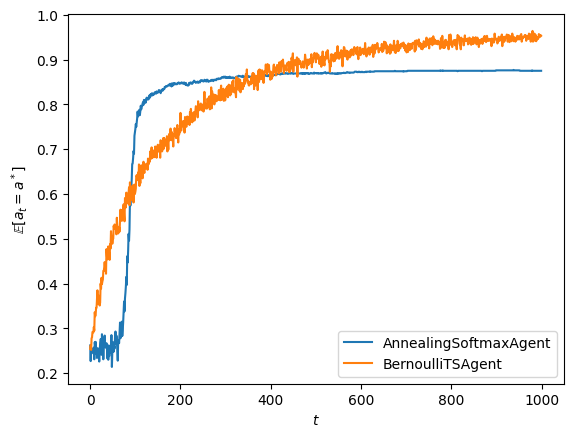

In [26]:
class BernoulliTSAgent(AgentInterface):
    def __init__(self) -> None:
        self.counts = np.zeros(n_arms)
        self.cumlative_rewards = np.zeros(n_arms)

    def get_arm(self) -> int:
        """各腕の報酬期待値の事後分布(信念)から、サンプリングを行い、最も報酬期待値が大きい腕を選択する
        報酬がbinary変数の場合、報酬期待値thetaの信念は、試行回数Nと観測報酬の和aに基づくベータ分布で表せることがわかっている。
        なので、各腕についてNとaだけ記録しておき、ベータ分布の確率密度関数で報酬期待値thetaの信念を計算。信念からサンプリングを行う。
        """
        beta_dist_func = lambda N, a: np.random.beta(a + 1, N - a + 1)
        sampled_thetas = [beta_dist_func(self.counts[i], self.cumlative_rewards[i]) for i in range(n_arms)]
        return int(np.argmax(sampled_thetas))

    def sample(self, arm: int, reward: int) -> None:
        # ベータ分布で解析的に事後分布を導出できるので、各腕について、試行回数と累積報酬のみ記録しておく
        self.counts[arm] += 1
        self.cumlative_rewards[arm] += reward


selected_arms_ts, observed_rewards_ts = simulation(BernoulliTSAgent, Env())
plt.plot(np.mean(selected_arms_annealing_softmax == Env().best_arm(), axis=0), label="AnnealingSoftmaxAgent")
plt.plot(np.mean(selected_arms_ts == Env().best_arm(), axis=0), label="BernoulliTSAgent")
plt.xlabel(r"$t$")
plt.ylabel(r"$\mathbb{E}[a_t = a^*]$")
plt.legend()
plt.show()


- トンプソンサンプリングは、epsilon-greedyやソフトマックスアルゴリズムと比較して、epsilonや温度パラメータなどを指定する必要がない点が特徴的。
  - 報酬を与える分布に対して適切な事前分布・事後分布を設計できさえすれば、ハイパーパラメータチューニングが不要なのが嬉しいポイント。

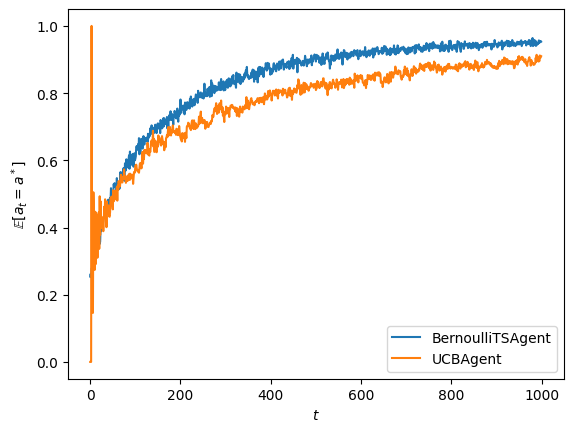

In [33]:
class UCBAgent(AgentInterface):
    def __init__(self) -> None:
        self.counts = [0 for _ in range(n_arms)]
        self.thetas_hat = [0 for _ in range(n_arms)]

    def get_arm(self) -> int:
        if 0 in self.counts:
            # もし一度も選択したことのない腕があれば決定的にそれを選ぶ(UCBスコアが無限大になっちゃうから)
            arm = self.counts.index(0)

        else:
            ucb_scores = [self._calc_ucb_score(arm) for arm in range(n_arms)]
            arm = ucb_scores.index(max(ucb_scores))
        return arm

    def _calc_ucb_score(self, arm: int) -> float:
        """報酬期待値の推定値に、報酬の未探索具合を決定的に加点してUCBスコアを計算する
        具体的な計算式は theta_hat + sqrt(log(sum(counts)) / 2 * counts)
        """
        ucb_score = self.thetas_hat[arm]
        ucb_score += np.sqrt(np.log(sum(self.counts)) / (2 * self.counts[arm]))
        return ucb_score

    def sample(self, arm: int, reward: int) -> None:
        self.counts[arm] = self.counts[arm] + 1
        self.thetas_hat[arm] = ((self.counts[arm] - 1) * self.thetas_hat[arm] + reward) / self.counts[arm]


selected_arms_ucb, observed_rewards_ucb = simulation(UCBAgent, Env())
plt.plot(np.mean(selected_arms_ts == Env().best_arm(), axis=0), label="BernoulliTSAgent")
plt.plot(np.mean(selected_arms_ucb == Env().best_arm(), axis=0), label="UCBAgent")
plt.xlabel(r"$t$")
plt.ylabel(r"$\mathbb{E}[a_t = a^*]$")
plt.legend()
plt.show()


- 質問: 「試しに新しい施策をユーザに見せるのはいいけど、それって今のものよりユーザ体験が悪いかもしれない。その場合、テスト中に生じる損失についてはどう考えてるの?? そもそもどれくらいの期間テストすれば十分と言えるの??」
- 回答の例: 「バンディットアルゴリズムを使うことで、実験期間中 (1 <= t <= T) の累積報酬が最大になるように努めます。その結果、累積報酬の期待値が最も大きいと推定されるvariantを実験後に採用します。」